In [130]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

## Load Dataset

In [131]:
!wget https://static-content.springer.com/esm/art%3A10.1186%2Fs40561-022-00192-z/MediaObjects/40561_2022_192_MOESM1_ESM.xlsx

--2023-06-05 16:49:30--  https://static-content.springer.com/esm/art%3A10.1186%2Fs40561-022-00192-z/MediaObjects/40561_2022_192_MOESM1_ESM.xlsx
Resolving static-content.springer.com (static-content.springer.com)... 151.101.0.95, 151.101.64.95, 151.101.128.95, ...
Connecting to static-content.springer.com (static-content.springer.com)|151.101.0.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68124 (67K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘40561_2022_192_MOESM1_ESM.xlsx.11’

40561_2022_192_MOES 100%[===================>]  66.53K  --.-KB/s    in 0.02s   

2023-06-05 16:49:30 (4.10 MB/s) - ‘40561_2022_192_MOESM1_ESM.xlsx.11’ saved [68124/68124]



In [132]:
data = pd.read_excel('40561_2022_192_MOESM1_ESM.xlsx')


print(data.head())

  stdID  mid-term  final                               faculty  \
0  std1        60     68  İKTİSADİ VE İDARİ BİLİMLER FAKÜLTESİ   
1  std2        34     67     BEDEN EĞİTİMİ VE SPOR YÜKSEKOKULU   
2  std3        25     75                      EĞİTİM FAKÜLTESİ   
3  std4        50     66                      EĞİTİM FAKÜLTESİ   
4  std5        50     66                      EĞİTİM FAKÜLTESİ   

                                         department  
0                   Siyaset Bilimi ve Kamu Yönetimi  
1                               Antrenörlük Eğitimi  
2  Bilgisayar ve Öğretim Teknolojileri Öğretmenliği  
3                      Sosyal Bilgiler Öğretmenliği  
4                          Okul Öncesi Öğretmenliği  


## Feature Engineering and One-hot encoding

In [133]:
# Drop irrelevant columns
data = data.drop(['stdID'], axis=1)

# One-hot encode the categorical features (faculty and department)
categorical_features = ['faculty', 'department']
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(data[categorical_features])
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
encoded_features_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)
data = pd.concat([data, encoded_features_df], axis=1)
data = data.drop(categorical_features, axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [134]:
# Create additional features

#Achievement grade is calculated by taking 40% of the midterm exam and 60% of the final exam. 
data['achievement_grade'] = (0.4 * data['mid-term']) + (0.6 * data['final'])

#Grade Difference: Calculate the absolute difference between the 'mid-term' and 'final' grades. This feature can capture how much a student's performance improved or declined from the mid-term to the final exam.
data['grade_difference'] = data['final'] - data['mid-term']

#Grade Ratio: Calculate the ratio of the 'mid-term' grade to the 'final' grade. This feature can capture the proportion of a student's performance in the mid-term exam compared to the final exam.
data['grade_ratio'] = data['mid-term'] / data['final']

#Grade Change: Calculate the difference between the 'mid-term' and 'final' grades and encode it as a binary feature indicating whether the grade increased or decreased. This can capture the direction of change in performance.
data['grade_change'] = np.where(data['final'] > data['mid-term'], 1, 0)

# Categorize grades based on the given ranges
data['midterm_category'] = pd.cut(data['mid-term'], bins=[0, 32.5, 55, 77.5, 100], labels=[1, 2, 3, 4])
data['final_category'] = pd.cut(data['final'], bins=[0, 32.5, 55, 77.5, 100], labels=[1, 2, 3, 4])
data['achievement_grade_category'] = pd.cut(data['achievement_grade'], bins=[0, 32.5, 55, 77.5, 100], labels=[1, 2, 3, 4])

In [135]:
# Prepare the feature matrix and target variable
X = data[['midterm_category', 'final_category', 'grade_difference', 'grade_ratio', 'grade_change'] + list(encoded_feature_names)]
y = data['achievement_grade_category']

In [136]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic Regression

In [137]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
logreg_pred = logreg.predict(X_test_scaled)
logreg_accuracy = accuracy_score(y_test, logreg_pred)
print("Logistic Regression Accuracy:", logreg_accuracy)
print(classification_report(y_test, logreg_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.8787061994609164
              precision    recall  f1-score   support

           1       0.67      0.80      0.73         5
           2       1.00      0.59      0.75        32
           3       0.88      0.92      0.90       206
           4       0.87      0.89      0.88       128

    accuracy                           0.88       371
   macro avg       0.85      0.80      0.81       371
weighted avg       0.88      0.88      0.88       371



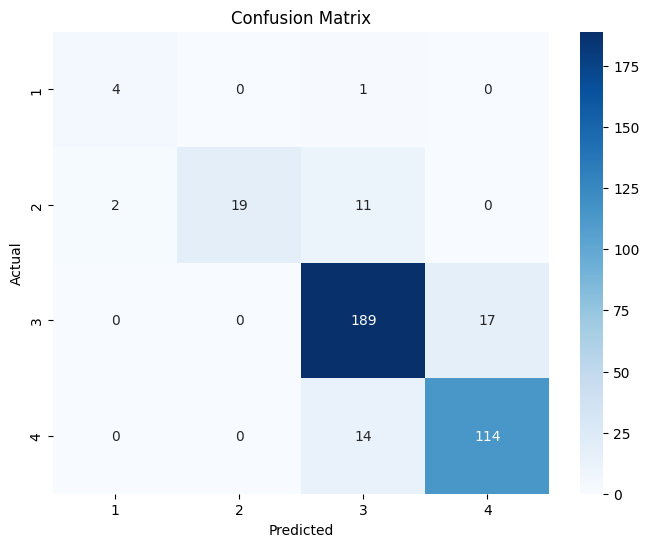

In [138]:
# Calculate the confusion matrix
confusion = confusion_matrix(y_test, logreg_pred)

# Define class labels
class_labels = ['1', '2', '3', '4']

# Create a DataFrame for the confusion matrix
confusion_df = pd.DataFrame(confusion, index=class_labels, columns=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Decision Tree

In [139]:
# Decision Tree
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_scaled, y_train)
dt_pred = dt_classifier.predict(X_test_scaled)
dt_accuracy = accuracy_score(y_test, dt_pred)
print("Decision Tree Accuracy:", dt_accuracy)
print(classification_report(y_test, dt_pred))


Decision Tree Accuracy: 0.921832884097035
              precision    recall  f1-score   support

           1       0.56      1.00      0.71         5
           2       0.88      0.69      0.77        32
           3       0.94      0.94      0.94       206
           4       0.92      0.95      0.94       128

    accuracy                           0.92       371
   macro avg       0.83      0.89      0.84       371
weighted avg       0.93      0.92      0.92       371



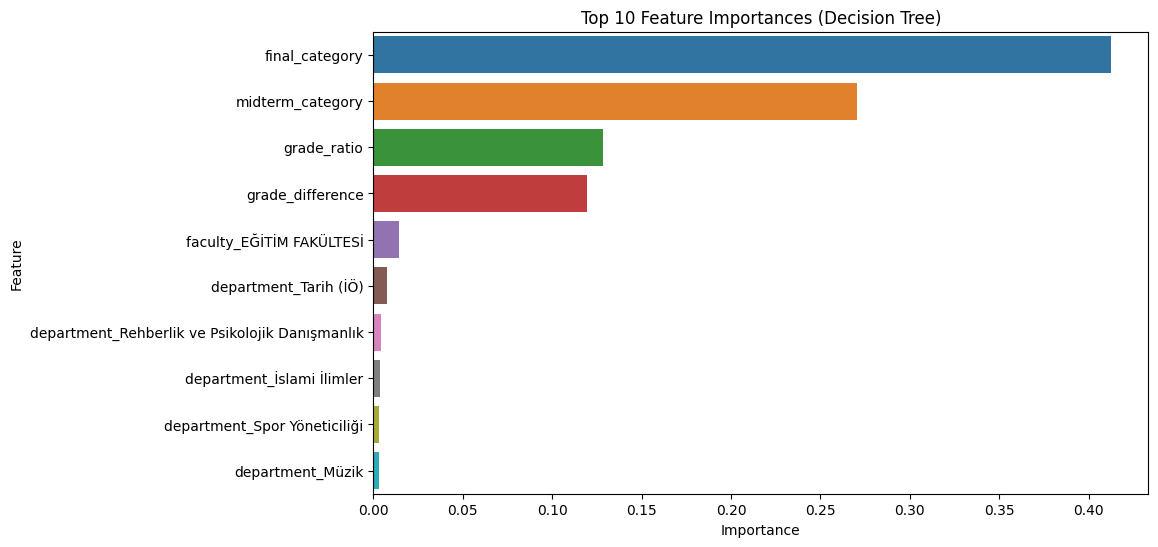

In [140]:
# Get feature importances
importances = dt_classifier.feature_importances_

# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the features by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Select the top 10 features
top_features = feature_importances.head(10)

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 10 Feature Importances (Decision Tree)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

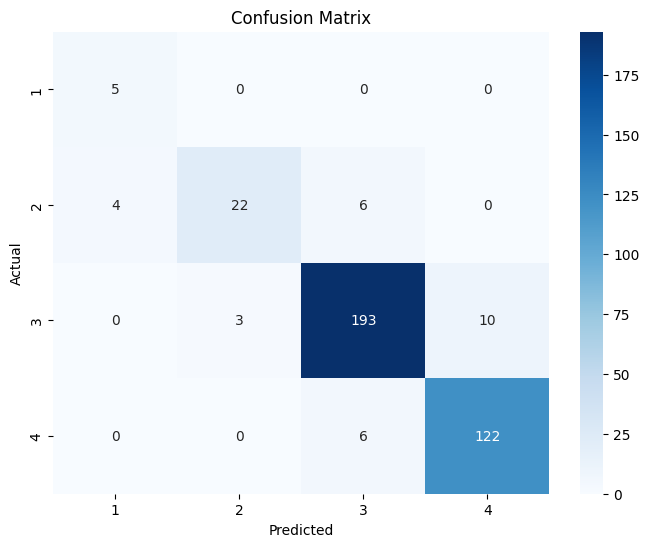

In [141]:
# Calculate the confusion matrix
confusion = confusion_matrix(y_test, dt_pred)

# Define class labels
class_labels = ['1', '2', '3', '4']

# Create a DataFrame for the confusion matrix
confusion_df = pd.DataFrame(confusion, index=class_labels, columns=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Random Forest

In [142]:
# Random Forest
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_scaled, y_train)
rf_pred = rf_classifier.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", rf_accuracy)
print(classification_report(y_test, rf_pred))

Random Forest Accuracy: 0.9056603773584906
              precision    recall  f1-score   support

           1       0.57      0.80      0.67         5
           2       0.89      0.75      0.81        32
           3       0.92      0.93      0.93       206
           4       0.91      0.91      0.91       128

    accuracy                           0.91       371
   macro avg       0.82      0.85      0.83       371
weighted avg       0.91      0.91      0.91       371



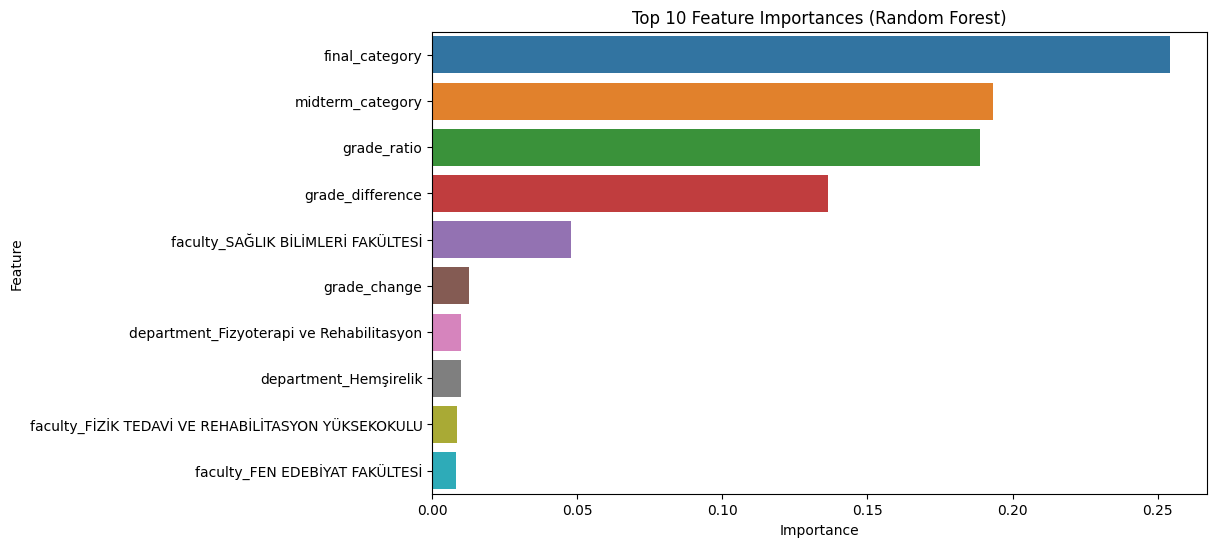

In [143]:
# Get feature importances
importances = rf_classifier.feature_importances_

# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the features by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Select the top 10 features
top_features = feature_importances.head(10)

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

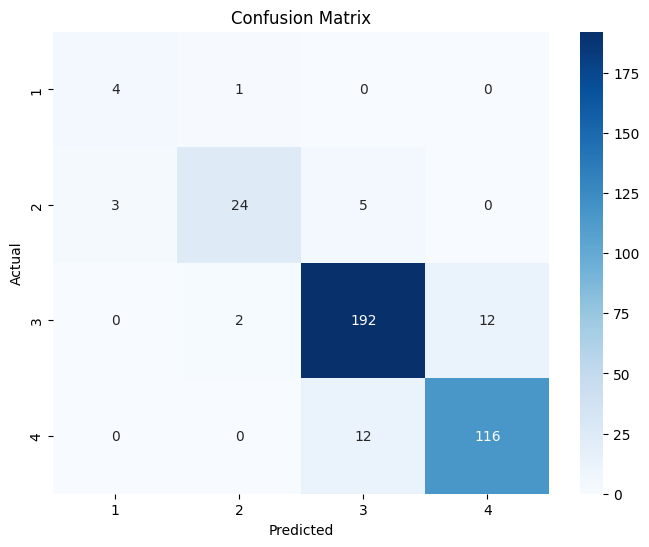

In [144]:
# Calculate the confusion matrix
confusion = confusion_matrix(y_test, rf_pred)

# Define class labels
class_labels = ['1', '2', '3', '4']

# Create a DataFrame for the confusion matrix
confusion_df = pd.DataFrame(confusion, index=class_labels, columns=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Support Vector Machine (SVM)

In [145]:
# SVM
svm_classifier = SVC()
svm_classifier.fit(X_train_scaled, y_train)
svm_pred = svm_classifier.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, svm_pred)
print("SVM Accuracy:", svm_accuracy)
print(classification_report(y_test, svm_pred))

SVM Accuracy: 0.8355795148247979
              precision    recall  f1-score   support

           1       0.50      0.20      0.29         5
           2       1.00      0.28      0.44        32
           3       0.79      0.96      0.87       206
           4       0.93      0.80      0.86       128

    accuracy                           0.84       371
   macro avg       0.80      0.56      0.61       371
weighted avg       0.85      0.84      0.82       371



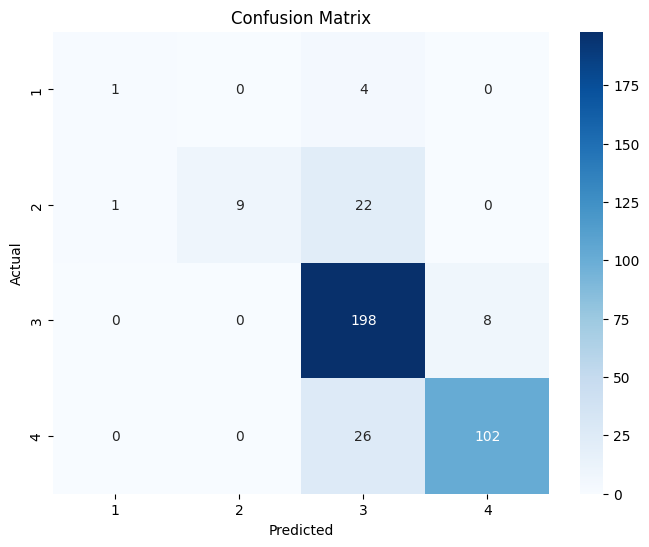

In [146]:
# Calculate the confusion matrix
confusion = confusion_matrix(y_test, svm_pred)

# Define class labels
class_labels = ['1', '2', '3', '4']

# Create a DataFrame for the confusion matrix
confusion_df = pd.DataFrame(confusion, index=class_labels, columns=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Naive Bayes

In [147]:
# Naive Bayes
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_scaled, y_train)
nb_pred = nb_classifier.predict(X_test_scaled)
nb_accuracy = accuracy_score(y_test, nb_pred)
print("Naive Bayes Accuracy:", nb_accuracy)
print(classification_report(y_test, nb_pred))

Naive Bayes Accuracy: 0.22371967654986524
              precision    recall  f1-score   support

           1       0.04      1.00      0.07         5
           2       0.09      0.41      0.15        32
           3       0.69      0.04      0.08       206
           4       0.69      0.44      0.54       128

    accuracy                           0.22       371
   macro avg       0.38      0.47      0.21       371
weighted avg       0.63      0.22      0.24       371



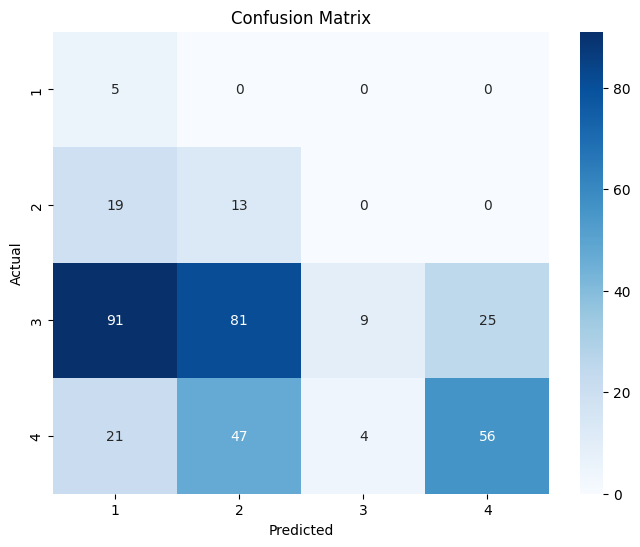

In [148]:
# Calculate the confusion matrix
confusion = confusion_matrix(y_test, nb_pred)

# Define class labels
class_labels = ['1', '2', '3', '4']

# Create a DataFrame for the confusion matrix
confusion_df = pd.DataFrame(confusion, index=class_labels, columns=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Compare metrics

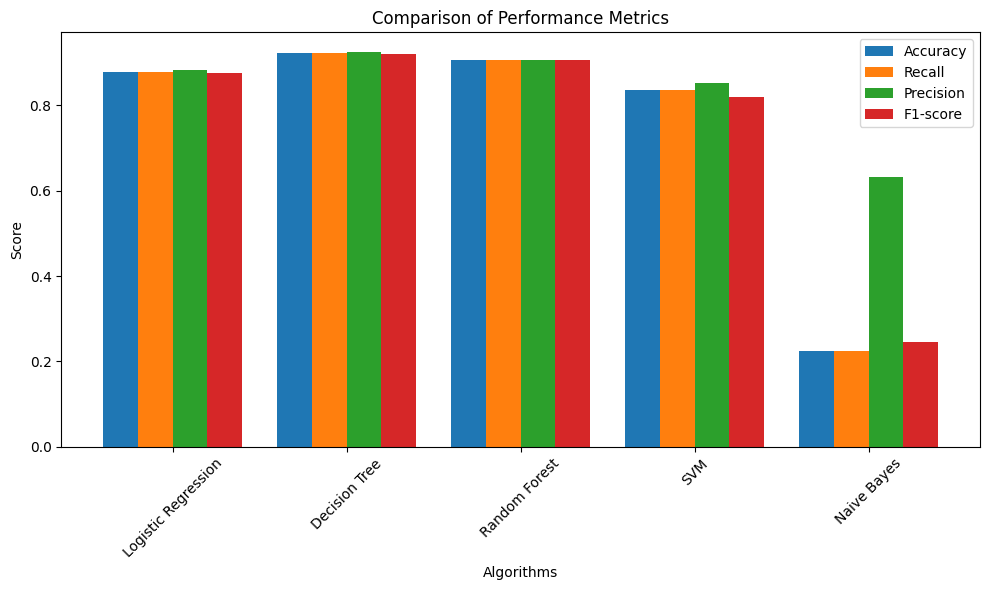

In [149]:
# Calculate metrics for each algorithm
accuracy = [logreg_accuracy, dt_accuracy, rf_accuracy, svm_accuracy, nb_accuracy]
recall = [classification_report(y_test, logreg_pred, output_dict=True)['weighted avg']['recall'],
          classification_report(y_test, dt_pred, output_dict=True)['weighted avg']['recall'],
          classification_report(y_test, rf_pred, output_dict=True)['weighted avg']['recall'],
          classification_report(y_test, svm_pred, output_dict=True)['weighted avg']['recall'],
          classification_report(y_test, nb_pred, output_dict=True)['weighted avg']['recall']]
precision = [classification_report(y_test, logreg_pred, output_dict=True)['weighted avg']['precision'],
             classification_report(y_test, dt_pred, output_dict=True)['weighted avg']['precision'],
             classification_report(y_test, rf_pred, output_dict=True)['weighted avg']['precision'],
             classification_report(y_test, svm_pred, output_dict=True)['weighted avg']['precision'],
             classification_report(y_test, nb_pred, output_dict=True)['weighted avg']['precision']]
f1 = [classification_report(y_test, logreg_pred, output_dict=True)['weighted avg']['f1-score'],
       classification_report(y_test, dt_pred, output_dict=True)['weighted avg']['f1-score'],
       classification_report(y_test, rf_pred, output_dict=True)['weighted avg']['f1-score'],
       classification_report(y_test, svm_pred, output_dict=True)['weighted avg']['f1-score'],
       classification_report(y_test, nb_pred, output_dict=True)['weighted avg']['f1-score']]

# Define the algorithms' names
algorithms = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'Naive Bayes']

# Define the metrics and their positions on the x-axis
metrics = ['Accuracy', 'Recall', 'Precision', 'F1-score']
x = np.arange(len(algorithms))
bar_width = 0.2

# Calculate the metrics for each algorithm
accuracy = [logreg_accuracy, dt_accuracy, rf_accuracy, svm_accuracy, nb_accuracy]
recall = [classification_report(y_test, logreg_pred, output_dict=True)['weighted avg']['recall'],
          classification_report(y_test, dt_pred, output_dict=True)['weighted avg']['recall'],
          classification_report(y_test, rf_pred, output_dict=True)['weighted avg']['recall'],
          classification_report(y_test, svm_pred, output_dict=True)['weighted avg']['recall'],
          classification_report(y_test, nb_pred, output_dict=True)['weighted avg']['recall']]
precision = [classification_report(y_test, logreg_pred, output_dict=True)['weighted avg']['precision'],
             classification_report(y_test, dt_pred, output_dict=True)['weighted avg']['precision'],
             classification_report(y_test, rf_pred, output_dict=True)['weighted avg']['precision'],
             classification_report(y_test, svm_pred, output_dict=True)['weighted avg']['precision'],
             classification_report(y_test, nb_pred, output_dict=True)['weighted avg']['precision']]
f1 = [classification_report(y_test, logreg_pred, output_dict=True)['weighted avg']['f1-score'],
       classification_report(y_test, dt_pred, output_dict=True)['weighted avg']['f1-score'],
       classification_report(y_test, rf_pred, output_dict=True)['weighted avg']['f1-score'],
       classification_report(y_test, svm_pred, output_dict=True)['weighted avg']['f1-score'],
       classification_report(y_test, nb_pred, output_dict=True)['weighted avg']['f1-score']]

# Plot the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x - 1.5*bar_width, accuracy, width=bar_width, label='Accuracy')
plt.bar(x - 0.5*bar_width, recall, width=bar_width, label='Recall')
plt.bar(x + 0.5*bar_width, precision, width=bar_width, label='Precision')
plt.bar(x + 1.5*bar_width, f1, width=bar_width, label='F1-score')

# Customize the plot
plt.xlabel('Algorithms')
plt.ylabel('Score')
plt.title('Comparison of Performance Metrics')
plt.xticks(x, algorithms, rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()